In [142]:
import numpy as np
import pandas as pd

This is a template for your final project. 

In [143]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

**Answer:** Let's select the all variables that can be potentially used a success metrics of the movie and make analysis of each of them. Those will be the variables that are out of production company's control. We can't use these variables to train our model, because it is impossible to know them before releasing a movie. Here is the list of such variables, lets call it potential target variables list:

- avg_vote
- votes
- usa_gross_income
- worlwide_gross_income
- metascore
- reviews_from_users
- reviews_from_critics

In [144]:
ptv_list = ['avg_vote', 'votes', 'usa_gross_income', 'worlwide_gross_income',
            'metascore', 'reviews_from_users', 'reviews_from_critics']

full_dataset[ptv_list].isna().sum() / full_dataset.shape[0] * 100

avg_vote                  0.000000
votes                     0.000000
usa_gross_income         80.245191
worlwide_gross_income    68.211568
metascore                85.361640
reviews_from_users        6.759361
reviews_from_critics     13.669889
dtype: float64

In [145]:
full_dataset.votes.value_counts().index.min()

100

Our dataset contains a lot of missing values for income columns and some missing values for review columns. Thus, we can't use them as target variables.

Thus, we will choose as our target variable the movie rating, which we can find in column **avg_vote**. Number of votes is not very important for us, because it says nothing about movie quality. However, from vote column we see that each movie's rating was calculated on at least 100 votes, so it makes avg_vote column even more valuable.

**Note.** I guess in real life it would depend on preferences of client and subject of target variable is subject of discussion with client. In fact, we could use income / budget ratio or other income related variables as target, getting rid of examples without such data, if it was crucially important for our client. For the sake of simplicity and in order to use as much data as possible I chose Average_vote as target variable.

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

Let's look at the range, in which our target variable lies.

<BarContainer object of 89 artists>

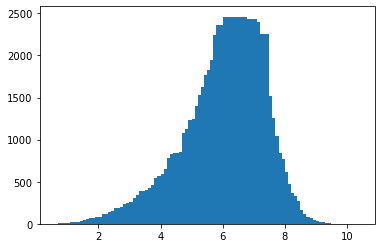

In [146]:
import matplotlib.pyplot as plt

a = full_dataset.avg_vote.value_counts()
plt.bar(a.index, a.values)

Here we see that it is movie rating is an float number between 0 and 10, so we can should solve regression task.

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it.

We will use mean squared error (MSE) as our metric for our regression task. Let's import it

In [147]:
from sklearn.metrics import mean_squared_error as mse

### Part 2.

Explore and preprocess the data

2.1 Split data into train and test

In [148]:
# First, we should drop all income-related and metascore columns, 
# because we identified that share of missing values is too big.
full_dataset.drop(['metascore', 'usa_gross_income', 'worlwide_gross_income'], axis=1, inplace=True)

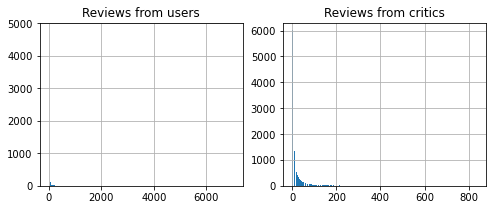

In [149]:
# We can also drop the columns with number of reviews from users and critics, because they are not informative
fig, axs = plt.subplots(1, 2, figsize=(8,3))

a = full_dataset.reviews_from_users.value_counts()
axs[0].bar(a.index, a.values, align='center')
axs[0].set_title('Reviews from users')
axs[0].grid()

a = full_dataset.reviews_from_critics.value_counts()
axs[1].bar(a.index, a.values, align='center')
axs[1].set_title('Reviews from critics')
axs[1].grid()

full_dataset.drop(['reviews_from_critics', 'reviews_from_users'], axis=1, inplace=True)

In [150]:
# Columns with movie title, imdb_id and description also don't give us any information about the movie
# Thus, we can drop them as well
# We can also drop publish date column, because we release year
full_dataset.drop(['imdb_title_id', 'title', 'original_title', 'description', 'date_published'], axis=1, inplace=True)

In [151]:
# Here we see, that the share of missing values for budget column is too high, so we drop that column too
full_dataset.isna().sum() / full_dataset.shape[0] * 100

year                   0.000000
genre                  0.000000
duration               0.000000
country                0.008306
language               0.729260
director               0.039868
writer                 1.342237
production_company     4.558291
actors                 0.049836
avg_vote               0.000000
votes                  0.000000
budget                72.060534
dtype: float64

In [152]:
full_dataset.drop(['budget'], axis=1, inplace=True)

In [153]:
# We should also drop the column with actors, because number of unique actors is more than 25 thousands. 
# Probably we could use top-100 frequent actors, but we still won't cover most part of our database.
# If we select more actors our model will be extremely complicated.
print(full_dataset.actors.str.split(', ', expand=True)[0].unique().shape)
full_dataset.drop(['actors'], axis=1, inplace=True)

(25082,)


In [154]:
# Finally we can drop column with numbers of votes, because we already know that each movie has at least 100 votes.
full_dataset.drop(['votes'], axis=1, inplace=True)

In [155]:
# Let's make a new column for each genre
genres = full_dataset.genre.str.split(', ', expand=True)
all_genres = set()
for i in range(0, genres.shape[1]):
    all_genres = all_genres.union(set(genres[i].unique()))
all_genres.remove(None)
for g in all_genres:
    full_dataset[g] = (genres[0] == g) | (genres[1] == g) | (genres[2] == g)

full_dataset.drop(['genre'], axis=1, inplace=True)

In [156]:
# Some observations in dataset has 2 or more values for columns country, director, writer, production_company.
# Let's select only first main value
full_dataset.country = full_dataset.country.str.split(', ', expand=True)[0]
full_dataset.writer = full_dataset.writer.str.split(', ', expand=True)[0]
full_dataset.director = full_dataset.director.str.split(', ', expand=True)[0]
full_dataset.production_company = full_dataset.production_company.str.split(', ', expand=True)[0]

In [157]:
bool_columns = list(full_dataset.dtypes[full_dataset.dtypes == 'bool'].index)
full_dataset[bool_columns] = full_dataset[bool_columns].astype('int')

In [158]:
# Now let's split our dataset to training and test sets.
from sklearn.model_selection import train_test_split

tr, te = train_test_split(full_dataset, test_size=0.2, random_state=42)

y_train = tr.avg_vote
y_test = te.avg_vote
X_train = tr.drop(['avg_vote'], axis=1)
X_test = te.drop(['avg_vote'], axis=1)

2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


In [159]:
# Let's see how many missing values do we have in each column and types of each column
type_df = pd.DataFrame(full_dataset.isna().sum())
type_df['data_types'] = full_dataset.dtypes
type_df

,0,data_types
year,0,int64
duration,0,int64
country,5,object
language,439,object
director,24,object
writer,808,object
production_company,2744,object
avg_vote,0,float64
Fantasy,0,int64
Drama,0,int64


In [160]:
# Now let's apply column transformer to each column
# We have to much unique variables for each categorical column, so we will apply label encoding.

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

categ_columns = list(full_dataset.dtypes[full_dataset.dtypes == 'object'].index)
int_columns = ['year', 'duration']

categ_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))
int_pipe = make_pipeline(StandardScaler())

column_transformer = ColumnTransformer([
    ('categ', categ_pipe, categ_columns),
    ('int', int_pipe, int_columns),
], remainder='passthrough')

new_data = pd.DataFrame(column_transformer.fit_transform(full_dataset))

In [161]:
# Now let's apply label encoding to categorcal features (label encoding didn't work inside pipeline)
def label_enc(df):
    for i in range(5):
        df[i] = le.fit_transform(df[i])
    return df

new_data = label_enc(new_data)
new_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,7,373,3004,4323,11443,-3.40264,-1.30729,6.1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,44,373,19814,28361,8989,-3.18812,-2.05444,5.9,0,1,...,0,0,0,0,0,0,0,0,0,0
2,129,373,2969,28636,10388,-3.14521,0.011215,5.2,0,1,...,0,0,0,0,0,0,0,0,0,0


In [162]:
# We couldn't use label encoder in pipeline, thus we have to split again our data after column transformations
tr, te = train_test_split(new_data, test_size=0.2, random_state=6)

y_train = tr[7]
y_test = te[7]
X_train = tr.drop([7], axis=1)
X_test = te.drop([7], axis=1)

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

In [163]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV

gb_param_grid = {'gb__n_estimators': [40, 80],
                 'gb__learning_rate' : [0.15],                 
                 'gb__min_samples_leaf': [3]
                }

rf_param_grid = {'rf__n_estimators': [40, 80],
                 'rf__min_samples_leaf': [3]
                }

lr_param_grid = {}
ridge_param_grid = {"ridge__alpha": [0.1, 1, 2]}

gb_pipe = Pipeline([('gb', GradientBoostingRegressor())])
rf_pipe = Pipeline([('rf', RandomForestRegressor())])
lr_pipe = Pipeline([('lr', LinearRegression())])
ridge_pipe = Pipeline([('ridge', Ridge())])

3.2 Use cross-validation to compare models and select best set of hyperparameters

In [164]:
gb_grid_model = GridSearchCV(gb_pipe, param_grid=gb_param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
gb_grid_model.fit(X_train, y_train)
best_gb_model = gb_grid_model.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40, score=-0.955, total=   2.6s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40, score=-0.950, total=   2.6s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40, score=-0.960, total=   2.6s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40 
[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40, score=-0.962, total=   2.6s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40 
[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=40, score=-0.956, total=   2.6s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=80 
[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=80, score=-0.941, total=   4.9s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=80 
[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=80, score=-0.933, total=   5.0s
[CV] gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=80 
[CV]  gb__learning_rate=0.15, gb__min_samples_leaf=3, gb__n_estimators=80, score=-0.946, total=   4.9s
[CV] gb__lea

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.7s finished


In [165]:
rf_grid_model = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
rf_grid_model.fit(X_train, y_train)
best_rf_model = rf_grid_model.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] rf__min_samples_leaf=3, rf__n_estimators=40 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__min_samples_leaf=3, rf__n_estimators=40, score=-0.915, total=   7.8s
[CV] rf__min_samples_leaf=3, rf__n_estimators=40 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  rf__min_samples_leaf=3, rf__n_estimators=40, score=-0.925, total=   7.7s
[CV] rf__min_samples_leaf=3, rf__n_estimators=40 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


[CV]  rf__min_samples_leaf=3, rf__n_estimators=40, score=-0.924, total=   7.7s
[CV] rf__min_samples_leaf=3, rf__n_estimators=40 .....................
[CV]  rf__min_samples_leaf=3, rf__n_estimators=40, score=-0.925, total=   7.7s
[CV] rf__min_samples_leaf=3, rf__n_estimators=40 .....................
[CV]  rf__min_samples_leaf=3, rf__n_estimators=40, score=-0.920, total=   7.7s
[CV] rf__min_samples_leaf=3, rf__n_estimators=80 .....................
[CV]  rf__min_samples_leaf=3, rf__n_estimators=80, score=-0.912, total=  15.4s
[CV] rf__min_samples_leaf=3, rf__n_estimators=80 .....................
[CV]  rf__min_samples_leaf=3, rf__n_estimators=80, score=-0.919, total=  15.2s
[CV] rf__min_samples_leaf=3, rf__n_estimators=80 .....................
[CV]  rf__min_samples_leaf=3, rf__n_estimators=80, score=-0.922, total=  15.2s
[CV] rf__min_samples_leaf=3, rf__n_estimators=80 .....................
[CV]  rf__min_samples_leaf=3, rf__n_estimators=80, score=-0.921, total=  15.4s
[CV] rf__min_samples_

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


In [166]:
lr_grid_model = GridSearchCV(lr_pipe, param_grid=lr_param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
lr_grid_model.fit(X_train, y_train)
best_lr_model = lr_grid_model.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... , score=-1.009, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................... , score=-1.011, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ................................... , score=-1.010, total=   0.4s
[CV]  ................................................................
[CV] ................................... , score=-1.018, total=   0.4s
[CV]  ................................................................
[CV] ................................... , score=-1.011, total=   0.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [167]:
ridge_grid_model = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
ridge_grid_model.fit(X_train, y_train)
best_ridge_model = ridge_grid_model.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] ridge__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... ridge__alpha=0.1, score=-1.009, total=   0.6s
[CV] ridge__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................... ridge__alpha=0.1, score=-1.011, total=   0.6s
[CV] ridge__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] ................... ridge__alpha=0.1, score=-1.010, total=   0.6s
[CV] ridge__alpha=0.1 ................................................
[CV] ................... ridge__alpha=0.1, score=-1.018, total=   0.6s
[CV] ridge__alpha=0.1 ................................................
[CV] ................... ridge__alpha=0.1, score=-1.011, total=   0.5s
[CV] ridge__alpha=1 ..................................................
[CV] ..................... ridge__alpha=1, score=-1.009, total=   0.4s
[CV] ridge__alpha=1 ..................................................
[CV] ..................... ridge__alpha=1, score=-1.011, total=   0.4s
[CV] ridge__alpha=1 ..................................................
[CV] ..................... ridge__alpha=1, score=-1.010, total=   0.4s
[CV] ridge__alpha=1 ..................................................
[CV] ..................... ridge__alpha=1, score=-1.017, total=   0.3s
[CV] ridge__alpha=1 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    8.3s finished


In [168]:
print(gb_grid_model.best_score_, gb_grid_model.best_estimator_, '\n',
      rf_grid_model.best_score_, rf_grid_model.best_estimator_, '\n',
      lr_grid_model.best_score_, lr_grid_model.best_estimator_, '\n',
      ridge_grid_model.best_score_, ridge_grid_model.best_estimator_
     )

-0.9420115094051631 Pipeline(memory=None,
         steps=[('gb',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.15, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=3,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=80,
                                           n_iter_no_change=None,
                                           presort='deprecated',
                                           r

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

**Answer.** Random Forest Regressor has minimal error -0.918 and provides the best predicition for movie_rating.

We can provide the client with following explanation. We made machine learning model that predicts the movie_rating within the following range (predicted rating - 2 * 0.915, predicted rating + 2 * 0.915) with probability 95% (assuming that client is satisfied with confidence interval of 95%).